# 1. Do some preparation

### Import necessary packages

In [1]:
import dgl
import torch
import torch.nn as nn
from dgl.nn.pytorch import GraphConv
import numpy as np
import networkx as nx
#import pandas as pd
import os
import torch.nn.functional as F
#from collections import OrderedDict
from itertools import chain
#import time

Using backend: pytorch


In [2]:
TORCH_DEVICE = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


### Define custom loss function for the QUBO matrix

In [3]:
def loss_func(probs_, Q_mat):
      """compute cost value for given soft assignments and predefined QUBO matrix
      """
      # minimize cost=x.T∗Q∗x
      cost = (probs_.T @ Q_mat @ probs_).squeeze()
      # cost = (probs_.T @ Q_mat @ probs_ + torch.sum(probs_)).squeeze() # a regularizer L1 or L2 does not seem to help
      return cost

### Generate the random z-regular graph and the QUBO matrix

In [4]:
def reg_graph(z, n, d0):
    """generate the random graph and QUBO matrix
    Returns
    -------
    g
        z-regular graph of n nodes with node-features of dimension d0
    Q
        QUBO matrix of MAX-CUT for this graph
    """
    G = nx.random_regular_graph(z, n, seed=1)
    assert not G.is_directed()
    m = G.number_of_edges()
    n = G.number_of_nodes()
    G = nx.relabel.convert_node_labels_to_integers(G)
    src = [u for u, v in G.edges()]
    dst = [v for u, v in G.edges()]
    g = dgl.graph(([], []))
    g.add_edges(src, dst)
    g.add_edges(dst, src)
    #g = dgl.to_bidirected(g)
    g.ndata["feat"] = torch.randn(n, d0)
    Q = dgl.khop_adj(g, 1) - torch.diag(g.in_degrees())
    return g, Q

### Calculate max cut number in a graph

In [5]:
def count_cuts2(g, best_str):
    """counts cuts in a graph
    Returns
    -------
    cuts_2
        number of cuts for the given graph g
    """
    # Count cuts using (7) in "Combinatorial Optimization with Physics-Inspired
    # Graph Neural Networks"
    bs = best_str.reshape(-1, 1)
    cuts_2 = -1/2 * np.sum(dgl.khop_adj(g, 1).numpy() * (2 * bs @ bs.T - bs.T - bs))
    return cuts_2

# 2. Training a GCN to solve the MC problem

### Define a chaotic optimizer

In [6]:
from torch.optim.optimizer import Optimizer, required

class SGD(Optimizer):
    r"""Implements stochastic gradient descent for CBP.

    -------------- Modified from SGD in PyTorch ----------------

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf

    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.

        Considering the specific case of Momentum, the update can be written as

        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + g_{t+1}, \\
                p_{t+1} & = p_{t} - \text{lr} * v_{t+1},
            \end{aligned}

        where :math:`p`, :math:`g`, :math:`v` and :math:`\mu` denote the
        parameters, gradient, velocity, and momentum respectively.

        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form

        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + \text{lr} * g_{t+1}, \\
                p_{t+1} & = p_{t} - v_{t+1}.
            \end{aligned}

        The Nesterov version is analogously modified.
    """

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, zs, Xs, closure=None, I=0.65, clip=False, clip_value=0.01):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for z, X, p in zip(zs, Xs, group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                # the updating rule modified by CBP
                cbp_grad = z * (I - X)
                if clip:
                    cbp_grad.clamp_(-clip_value, clip_value)
                # p.add_(d_p, alpha=-group['lr']).add_(I - X, alpha=z)
                p.add_(d_p, alpha=-group['lr']).add_(cbp_grad)
        return loss

### Define a custom GCN with hidden outputs

In [7]:
class GCN_my(nn.Module):
    def __init__(self, in_feats, hidden_size, number_classes, dropout, device, dscale=1.):
        """
        Initialize a new instance of the core GCN model of provided size.
        Dropout is added in forward step.
        Inputs:
            in_feats: Dimension of the input (embedding) layer
            hidden_size: Hidden layer size
            dropout: Fraction of dropout to add between intermediate layer. Value is cached for later use.
            device: Specifies device (CPU vs GPU) to load variables onto
        """
        super(GCN_my, self).__init__()

        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, number_classes).to(device)
        self.dscale = dscale

    def forward(self, g, inputs, random_pick=False, spe_idx=0):
        """
        Run forward propagation step of instantiated model.
        Input:
            self: GCN_dev instance
            g: DGL graph object, i.e. problem definition
            inputs: Input (embedding) layer weights, to be propagated through network
        Output:
            h: Output layer weights
        """
        h1 = torch.sigmoid(inputs * self.dscale)
            
        # input step
        o1 = self.conv1(g, inputs)
        h2 = torch.sigmoid(o1 * self.dscale)
        o1 = torch.relu(o1)
        o1 = F.dropout(o1, p=self.dropout_frac)

        # output step
        o2 = self.conv2(g, o1)
        h3 = torch.sigmoid(o2 * self.dscale)
        o2 = torch.sigmoid(o2)
        
        if random_pick: 
            idx = np.random.choice(range(len(o2))) 
        else :
            idx = spe_idx

        return o2, [h1, h2[idx], h2[idx], h3[idx], h3[idx]]

### Define the training function using CGBP

In [8]:
import random
def set_random_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [9]:
def train_with_chaos(graph_dgl, 
                     q_torch, 
                     zs, 
                     max_iter=10000, 
                     cbp_epoch=1000,
                     lr=1e-4,
                     beta=0.999, 
                     seed=1, 
                     random_pick=False, 
                     spe_idx=0,
                     dscale=1.,
                     cbp_momentum=0.,
                     momentum=0.,
                     adam=False,
                     dropout=0.,
                     prob_threshold=.5,
                     record_weights=False,
                    ):
    set_random_seed(seed)

    nnodes = graph_dgl.num_nodes()
    dim_embedding = int(np.sqrt(nnodes))
    hidden_dim = int(dim_embedding/2)
    
    embed = nn.Embedding(nnodes, dim_embedding).type(q_torch.dtype).to(q_torch.device)

    mygcn = GCN_my(dim_embedding, hidden_dim, 1, dropout, TORCH_DEVICE, dscale=dscale)
    optimizer = SGD(chain(embed.parameters(), mygcn.parameters()), lr=lr, momentum=cbp_momentum)
    inp = embed.weight

    # initialize optimal solution
    best_bitstring = torch.zeros((graph_dgl.number_of_nodes(),)).type(q_torch.dtype).to(q_torch.device)
    best_loss = loss_func(best_bitstring.float(), q_torch).item()
    
    ebd=[]
    loss_list = []
    ws1 = []
    ws2 = []

    for epoch in range(cbp_epoch):
        out, hid = mygcn(graph_dgl, inp, random_pick=random_pick, spe_idx=spe_idx)
        loss = loss_func(out[:, 0], q_torch)
        
        loss_item = loss.item()
        
        loss_list.append(loss_item)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step(zs, hid)
        zs *= beta
        
        if loss_item < best_loss:
            best_loss = loss_item
            best_bitstring = (out.detach().numpy().flatten() >= prob_threshold) * 1
            
        if record_weights:
            ebd.append(embed.weight.detach().numpy()[:2].flatten())
            ws1.append(mygcn.conv1.weight.detach().numpy().flatten())
            ws2.append(mygcn.conv2.weight.detach().numpy().flatten())
    
    if adam:
        optimizer = torch.optim.Adam(chain(embed.parameters(), mygcn.parameters()), lr=lr)
    else:
        optimizer = torch.optim.SGD(chain(embed.parameters(), mygcn.parameters()), lr=lr, momentum=momentum)
        
    for epoch in range(cbp_epoch, max_iter):
        out, hid = mygcn(graph_dgl, inp)
        loss = loss_func(out[:, 0], q_torch)
        loss_item = loss.item()
        loss_list.append(loss_item)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss_item < best_loss:
            best_loss = loss_item
            best_bitstring = (out.detach().numpy().flatten() >= prob_threshold) * 1
            
        if record_weights:
            ebd.append(embed.weight.detach().numpy()[:2].flatten())
            ws1.append(mygcn.conv1.weight.detach().numpy().flatten())
            ws2.append(mygcn.conv2.weight.detach().numpy().flatten())
        
    final_bitstring = (out.detach().numpy().flatten() >= prob_threshold) * 1
            
    return loss_list, ebd, ws1, ws2, best_bitstring, final_bitstring

### Generate the input graph

In [10]:
n = 100 # number of nodes
z = 3 # degree of each node
d0 = int(np.sqrt(n))
g, Q_mat = reg_graph(z, n, d0)

### Define hyperparameters shared by both BP and CGBP

In [11]:
max_iter = 10000 # max epoch
lr = 0.0001 # learning rate
adam = True # using Adam optimizer
nrun = 3 # number of independent runs using different seed; set to 100 to reproduce the results in the paper

### BP training example

In [12]:
cbp_epoch = 0 # z will be set to 0 at this epoch
bp_best_bits = []
for seed in range(nrun):
    zs = np.zeros(5) # chaotic intensity z = 0 implies that CGBP degenerates to BP
    loss_list, ebd, ws1, ws2, best_bitstring, final_bitstring = train_with_chaos(
        g, Q_mat, zs, max_iter=max_iter, cbp_epoch=cbp_epoch, lr=lr,seed=seed, adam=adam)
    bp_best_bits.append(best_bitstring)

### CGBP training example

In [13]:
cbp_epoch = 800 # z will be set to 0 at this epoch
dscale = 10. # The steepness factor that controls the chaotic range, the larger it is, the smaller the chaotic range is.
cgbp_best_bits = []
for seed in range(nrun):
    zs = np.array([20., 3., 3., 1., 1.]) / dscale # 20 for embedding layer; 3 for first GNN layer and 1 for second GNN layer.
    loss_list, ebd, ws1, ws2, best_bitstring, final_bitstring = train_with_chaos(
        g, Q_mat, zs, max_iter=max_iter, cbp_epoch=cbp_epoch, lr=lr, seed=seed, dscale=dscale, adam=adam)
    cgbp_best_bits.append(best_bitstring)

# 3. Comparing and visualizing the results

### Define plot function for the obtained graph

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='notebook', style='ticks', font_scale=1.5)

def plot_graph(nx_graph, bestbit, figsize=(10, 10), mis_color='lightblue', other_color='orange', **params):
    cmap = [other_color if (bestbit[node] == 0) else mis_color for node in nx_graph.nodes()]
    pos = nx.kamada_kawai_layout(nx_graph)
    fig, ax = plt.subplots(figsize=figsize)
    nx.draw(nx_graph, pos, with_labels=False, node_color=cmap, ax=ax, **params)
    return ax

In [15]:
def bs_to_cs(graph_nx, bs):
    cs = []
    for edge in graph_nx.edges:
        src, tgt, _= edge
        if bs[src] == bs[tgt]:
            cs.append('gray')
        else:
            cs.append('red')
    return cs

### Plot the MC results for BP

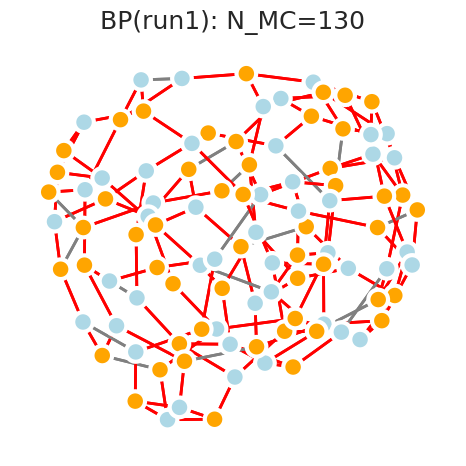

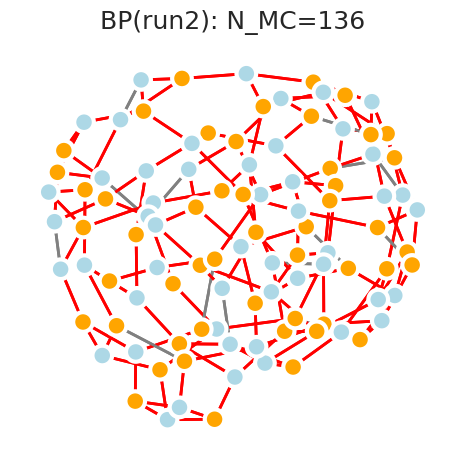

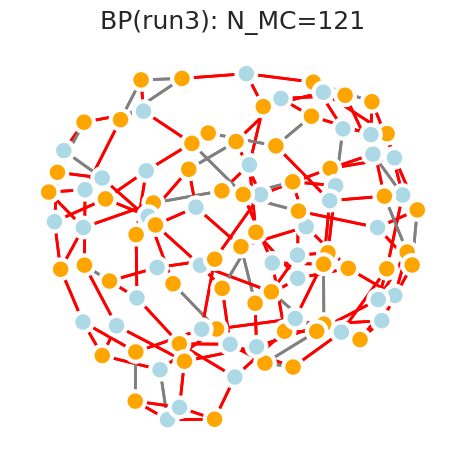

In [20]:
for i, best_bit in enumerate(bp_best_bits):
    mc_num = int(count_cuts2(g, best_bit)) # max cut number
    edge_color = bs_to_cs(g.to_networkx(), best_bit)
    ax = plot_graph(g.to_networkx(), best_bit, figsize=(5, 5), other_color='orange', node_size=200, 
                    arrows=False, edge_color=edge_color, linewidths=3, width=2, edgecolors='w')
    plt.title(f"BP(run{i+1}): N_MC={mc_num}")
    plt.tight_layout()
    plt.savefig(f'bp_run{i+1}_mc.pdf')

### Plot the MC results for CGBP

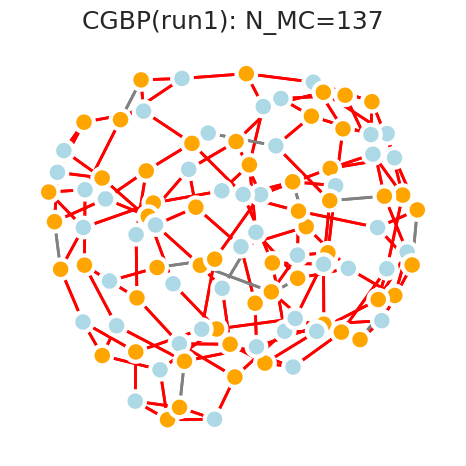

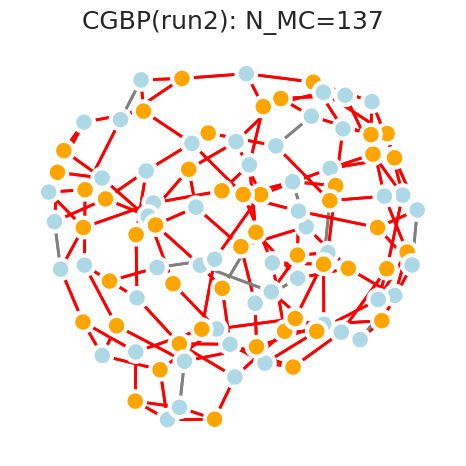

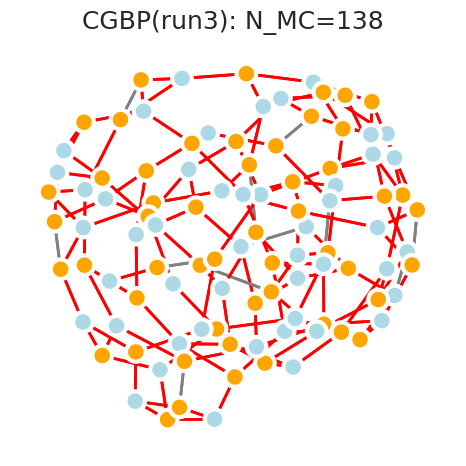

In [21]:
for i, best_bit in enumerate(cgbp_best_bits):
    mc_num = int(count_cuts2(g, best_bit))
    edge_color = bs_to_cs(g.to_networkx(), best_bit)
    ax = plot_graph(g.to_networkx(), best_bit, figsize=(5, 5), other_color='orange', node_size=200, 
                    arrows=False, edge_color=edge_color, linewidths=3, width=2, edgecolors='w')
    plt.title(f"CGBP(run{i+1}): N_MC={mc_num}")
    plt.tight_layout()
    plt.savefig(f'cgbp_run{i+1}_mc.pdf')

### Related code
- https://github.com/amazon-science/co-with-gnns-example  
- https://github.com/amazon-science/gcp-with-gnns-example  
- https://github.com/riccardodv/PI-GNN-implementation  
- https://github.com/PengTao-HUST/CBP  